In [ ]:
%%capture
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset, SequentialSampler

from collections import Counter
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Dataset Loading

In [ ]:
## Give Rootpath of data.
root_path = '/hagrid_yolo_format'

In [ ]:
class HagridDataset(Dataset):
    def __init__(self, root_path, datatype,S=7, transform=None):
        self.root_path = root_path
        self.imgs_path = [path.strip() for path in open(self.root_path + f'/{datatype}.txt', 'r').readlines()]
        self.labels_path = [path.replace(datatype, f'{datatype}_labels').replace('.jpg', '.txt').replace('.png', '.txt') for path in self.imgs_path]
        self.S = S
        self.transform = transform

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        img = Image.open(img_path)

        img = img.resize((448, 448), Image.BILINEAR)
        img = np.array(img)

        if self.transform:
            img = self.transform(img)

        raw_labels = [path.strip() for path in open(self.labels_path[idx], 'r').readlines()]
        raw_labels = [label for label in raw_labels if len(label) > 0]
        raw_labels = [[int(classId), float(x), float(y), float(w), float(h)] for classId, x, y, w, h in [label.split() for label in raw_labels]]

        labels = torch.zeros((self.S, self.S, 24))
        for label in raw_labels:
            c, x, y, w, h = label
            row, col = int(y*self.S), int(x*self.S)
            x_cell, y_cell = x*self.S - col, y*self.S - row
            width, height = w*self.S, h*self.S

            ## Set the class label.
            labels[row, col, c] = 1
            ## Set the prob.
            labels[row, col, 19] = 1
            labels[row, col, 20:24] = torch.tensor([x_cell, y_cell, width, height])

        return img, labels

### Setup Loss function

In [ ]:
class Loss(nn.Module):
    def __init__(self, S=7, C=19):
        super(Loss, self).__init__()
        self.S = S   ## Grid size
        self.C = C     ## Number of classes

    def forward(self, predictions, actual_labels, lambda_coord=5, lambda_obj=1, lambda_noobj=0.5):

        mask = actual_labels[..., 19]
        ## BB loss
        loss_xy = lambda_coord * torch.sum(mask * torch.sum((actual_labels[..., 20:22] - predictions[..., 20:22])**2, dim=-1))
        loss_wh = lambda_coord * torch.sum(mask * torch.sum((actual_labels[..., 22:24] - predictions[..., 22:24])**2, dim=-1))
        ## Objectness loss
        loss_obj = lambda_obj  * torch.sum(mask * (actual_labels[..., 19] - predictions[..., 19])**2)
        loss_noobj = lambda_noobj * torch.sum((1 - mask) * (actual_labels[..., 19] - predictions[..., 19])**2)
        ## Class loss
        loss_class = torch.sum(mask * torch.sum((actual_labels[..., :19] - predictions[..., :19])**2, dim=-1))

        return (loss_xy + loss_wh + loss_obj + loss_noobj + loss_class)/actual_labels.shape[0]   ## Normalize by batch size

### Initiate Model.

In [ ]:
class airdraw(nn.Module):
    def __init__(self, backbone, freeze_backbone = True):
        super(airdraw, self).__init__()
        self.backbone = backbone            ## Output is Channnels : 2048, Size is 14*14 for a image size of 448,448
        if freeze_backbone:
            self.backbone.requires_grad_(False)

        self.predictor = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1), ## 1024, 14, 14
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), ## 1024, 14, 14
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1), ## 1024, 7, 7
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), ## 1024, 7, 7
            nn.LeakyReLU(0.1),
            nn.Flatten(), ## 512*7*7
            nn.Linear(512*7*7, 2028), ## 2028
            nn.LeakyReLU(0.1),
            nn.Linear(2028, 7*7*24), ## 1176
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.reshape(-1, 2048, 14, 14)
        x = self.predictor(x)
        x = x.reshape(-1, 7, 7, 24)
        return x

In [ ]:
## Import and freeze the backbone
model_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

## Remove the last two layers
model_resnet.avgpool = nn.Identity()
model_resnet.fc = nn.Identity()

model = airdraw(model_resnet, freeze_backbone=True)

model = model.to(device)

In [ ]:
criterion = Loss(S=7, C=19)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def lr_lambda(epoch):
    if epoch < 3:
        return 1
    elif epoch > 2 and epoch < 6:
        return 10
    elif epoch > 5 and epoch < 9:
        return 1
    else:
        return 0.1

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Initialize Datasets.

In [ ]:
## Initialize the dataloaders.
train_dataset = HagridDataset(root_path, 'train', transform = transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, drop_last=True)

### Training Loop

In [ ]:
# Training loop for model.
num_epochs = 10

losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader)):
        ## Send the data to GPU.
        if device == "cpu":
          images, labels = data
        else:
          images, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        ## Forward Pass.
        output = model(images)

        ## Calculate Loss
        loss = criterion(output, labels)

        ## Backward Pass
        loss.backward()

        ## Update the Parameters as per the provided optimizer.
        optimizer.step()

        # scheduler.step()

        running_loss += loss.item()

    # print(f'Epoch [{epoch+1}/{num_epochs}], Epoch Loss: {running_loss:.4f}')
    losses.append(running_loss)

print('Finished Training')

Losses :  [23112.77441549301, 10528.158617377281, 7912.854707181454, 6019.053724467754, 4745.234266936779, 3870.795787602663, 3228.8120054602623, 2694.614437133074, 2258.3250573426485, 1899.2088861465454]


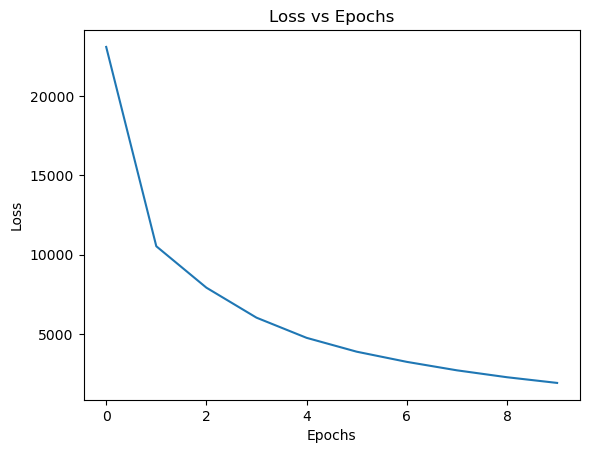

In [ ]:
print("Losses : ", losses)
plt.plot(np.arange(len(losses)),losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

In [ ]:
# torch.save(model, 'resnet_based_cnn.pth')

In [ ]:
## Define Test Loader.
test_dataset = HagridDataset(root_path, 'test', transform = transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=True)

## Qualitative Evaluation

In [ ]:
model = torch.load('resnet_based_cnn.pth')

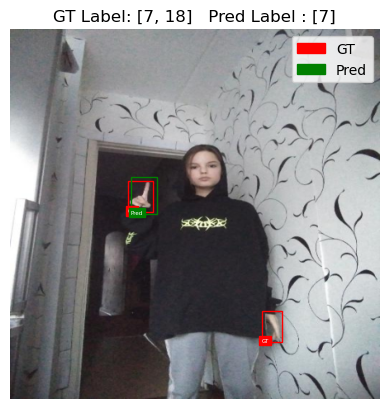

In [ ]:
## Make inference on the Test dataset.
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        if device == "cpu":
          images, labels = data
        else:
          images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        ## Get First Image
        outputs = outputs[i]
        labels = labels[i]

        bbx_pred_idx_x, bbx_pred_idx_y = torch.where(outputs[..., 19] > 0.5)
        bbx_label_idx_x, bbx_label_idx_y = torch.where(labels[..., 19] > 0.5)

        ## Get the label.
        pred_label = torch.argmax(outputs[bbx_pred_idx_x,bbx_pred_idx_y, :19], dim=-1)
        actual_label = torch.argmax(labels[bbx_label_idx_x,bbx_label_idx_y, :19], dim=-1)

        plt.imshow(images[0].permute(1, 2, 0).to('cpu').numpy())
        ## Plot actual bounding boxes.
        for i in range(bbx_label_idx_x.shape[0]):
          row = bbx_label_idx_x[i].item()
          col = bbx_label_idx_y[i].item()

          x, y, w, h = labels[row, col, 20:24]
          x, y, w, h = x.item(), y.item(), w.item(), h.item()
          x = (x + col)/7
          y = (y + row)/7
          w = w/7
          h = h/7
          plt.gca().add_patch(patches.Rectangle((x-w/2, (1-(y+h/2))), w, h, linewidth=1, edgecolor='r', facecolor='none',transform=plt.gca().transAxes, label='GT'))
          plt.gca().text(x-w/2, (1-(y+h/2)), 'GT', color='w',backgroundcolor='r', fontsize=4,transform=plt.gca().transAxes)
        ## Go inside a loop and get the bounding boxes, and then plot them.
        for i in range(bbx_pred_idx_x.shape[0]):
          row = bbx_pred_idx_x[i].item()
          col = bbx_pred_idx_y[i].item()

          x, y, w, h = outputs[row, col, 20:24]
          x, y, w, h = x.item(), y.item(), w.item(), h.item()
          x = (x + col)/7
          y = (y + row)/7
          w = w/7
          h = h/7
          plt.gca().add_patch(patches.Rectangle((x-w/2, (1-(y+h/2))), w, h, linewidth=1, edgecolor='g', facecolor='none',transform=plt.gca().transAxes, label='Pred'))
          plt.gca().text(x-w/2, (1-(y+h/2)), 'Pred', color='w',backgroundcolor='g', fontsize=4, transform=plt.gca().transAxes)

        plt.title(f'GT Label: {[label.item() for label in actual_label]}   Pred Label : {[label.item() for label in pred_label]}')
        plt.legend(handles=[patches.Patch(color='r', label='GT'), patches.Patch(color='g', label='Pred')])
        plt.axis('off')
        plt.show()
        break

## Quantitative Evaluation

### Helper Functions

In [ ]:
def getIou(box1, box2):
    """
    Input are list of coordinate of opposite corners of the boxes.
    box1 : [x1, y1, x2, y2]
    box2 : [x1, y1, x2, y2]
    returns : float iou"""
    ## Cordi of intersection box.
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    ## Intersection area.
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    ## Area of boxes.
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    ## Area of Union.
    area_union = box1_area + box2_area - intersection_area

    iou = intersection_area/area_union

    return iou

def cell2image(row, col, output):
    '''
    Input is cell number and label tensor.
    row, col : int
    output : tensor of shape (7, 7, 24)

    returns : list of coordinates of bounding box.
    bounding box : [x,y,w,h].
    '''
    x, y, w, h = output[row, col, 20:24]
    x, y, w, h = x.item(), y.item(), w.item(), h.item()
    x = (x + col)/7
    y = (y + row)/7
    w = w/7
    h = h/7

    return [x,y,w,h]

def center2corner(x, y, w, h):
    """"Converts center coordinates to corner coordinates"""
    x1 = x - w/2
    y1 = y - h/2
    x2 = x + w/2
    y2 = y + h/2
    return [x1, y1, x2, y2]

def nms(output, threshold=0.5):
    '''
    Input is the output tensor of model for one image.
    output : tensor of shape (7, 7, 24)

    returns : list of coordinates of bounding box.
    bounding box : [x1, y1, x2, y2] as opposite corners points of bb.
    '''
    ## Get the indexes of the bounding boxes with prob > 0.5
    bbx_pred_idx_x, bbx_pred_idx_y = torch.where(output[..., 19] > 0.5)

    ## Get the bounding boxes with respect to image.
    bounding_boxes = []
    for i in range(bbx_pred_idx_x.shape[0]):
        row = bbx_pred_idx_x[i].item()
        col = bbx_pred_idx_y[i].item()
        bb_wrt_cell = cell2image(row, col, output)
        bb_corner = center2corner(*bb_wrt_cell)
        bounding_boxes.append(bb_corner)

    ## Sort the bounding boxes by their prob.
    bounding_boxes = sorted(bounding_boxes, key = lambda x: output[int(x[1]*7), int(x[0]*7), 19], reverse=True)
    print("Number of bounding boxes before NMS : ", len(bounding_boxes))

    final_bounding_boxes = []
    while len(bounding_boxes) > 0:
        final_bounding_boxes.append(bounding_boxes[0])
        bounding_boxes = bounding_boxes[1:]
        bounding_boxes = [bb for bb in bounding_boxes if getIou(final_bounding_boxes[-1], bb) < threshold]
    print("Number of bounding boxes after NMS : ", len(final_bounding_boxes))
    return final_bounding_boxes

def output2bbx(outputs, batch_num):
    '''Takes the output tensor of model and returns the bounding boxes for each image.'''
    bounding_boxes_batch = [] ## ##[img_idx, class, prob, x1, y1, x2, y2]
    for idx, output in enumerate(outputs):
        bounding_boxes_image = []
        bbx_pred_idx_x, bbx_pred_idx_y = torch.where(output[..., 19] > 0.5)
        for i in range(bbx_pred_idx_x.shape[0]):
            row = bbx_pred_idx_x[i].item()
            col = bbx_pred_idx_y[i].item()
            bb_wrt_image = cell2image(row, col, output)
            bb_corner = center2corner(*bb_wrt_image)
            bounding_boxes_image.append([idx + batch_num*outputs.shape[0], torch.argmax(output[row, col, :19]).item(), output[row, col, 19].item()] + bb_corner)
            final_bbs_images = nms_new(bounding_boxes_image)
    return final_bbs_images

def mAP(pred_bbx, actual_bbx, classes=19, threshold=0.5):
    """Input if all the outputs and labels for the dataset.
    outputs : list of N , [idx, class, prob, x, y, w, h]
    labels : list of N , [idx, class, prob, x, y, w, h]
    classes : int
    threshold : float
    Output is the mAP score for the dataset."""
    average_precisions = []
    for curr_class in range(classes):

        detections = [box for box in pred_bbx if box[1] == curr_class]
        ground_truths = [box for box in actual_bbx if box[1] == curr_class]

        # print(len(detections), len(ground_truths))

        ## Create a dictionary to store VISIT check. For each image, we will store the number of bounding boxes.
        visited = Counter(box[0] for box in ground_truths)
        visited = {key: [0]*visited[key] for key in visited.keys()}

        ## Sort the detections by their score.
        detections = sorted(detections, key = lambda x: x[3], reverse=True)

        ## Initialize the variables.
        true_positives = torch.zeros(len(detections))
        false_positives = torch.zeros(len(detections))
        total_positives = len(ground_truths)

        for idx, detection in enumerate(detections):
            ground_truth_boxs_4_this_detection = [bb for bb in ground_truths if bb[0] == detection[0]]
            ious = [getIou(detection[3:], gt[3:]) for gt in ground_truth_boxs_4_this_detection]
            if ious:
                if max(ious) > threshold:
                    if visited[detection[0]][ious.index(max(ious))] != 1:
                        true_positives[idx] = 1
                        visited[detection[0]][ious.index(max(ious))] = 1
                    else:
                        false_positives[idx] = 1
                else:
                    false_positives[idx] = 1
            else:
                false_positives[idx] = 1

        ## Compute the precision and recall.
        cum_true_positives = torch.cumsum(true_positives, dim=0)
        cum_false_positives = torch.cumsum(false_positives, dim=0)

        epsilon = 1e-6
        precision = cum_true_positives/(cum_true_positives + cum_false_positives + epsilon)
        recall = cum_true_positives/total_positives

        precision = torch.cat((torch.tensor([1]), precision))
        recall = torch.cat((torch.tensor([0]), recall))

        average_precisions.append(torch.trapz(precision, recall))

    return sum(average_precisions)/classes

def nms_new(bounding_boxes, threshold=0.5):
    ''''Input BBs are : idx, class, prob, x1, y1, x2, y2'''
    bounding_boxes = sorted(bounding_boxes, key = lambda x: x[2], reverse=True)
    final_bounding_boxes = []
    while bounding_boxes:
        final_bounding_boxes.append(bounding_boxes[0])
        bounding_boxes = bounding_boxes[1:]
        bounding_boxes = [bb for bb in bounding_boxes if getIou(bb[3:], final_bounding_boxes[-1][3:]) < threshold]
    return final_bounding_boxes

In [ ]:
## Make inference on the subset dataset.
model.eval()
with torch.no_grad():
    all_pred_bounding_boxes = [] ##[img_idx, class, prob, x1, y1, x2, y2]
    all_actual_bounding_boxes = []
    for i, data in tqdm(enumerate(test_loader)):
        if device == "cpu":
          images, labels = data
        else:
          images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)

        all_actual_bounding_boxes += output2bbx(labels, i)
        all_pred_bounding_boxes += output2bbx(outputs, i)

mAP_score_50 = mAP(all_pred_bounding_boxes, all_actual_bounding_boxes, classes=19, threshold=0.5)
print("mAP Score @ 50 : ", mAP_score_50)

mAP_50_95 = torch.mean(torch.tensor([mAP(all_pred_bounding_boxes, all_actual_bounding_boxes, classes=19, threshold=i/100) for i in range(50, 100, 5)]))

print("mAP Score @ 50-95 : ", mAP_50_95)

2813it [10:56,  4.29it/s]


mAP Score @ 50 :  tensor(0.6826)
mAP Score @ 50-95 :  tensor(0.3816)
